# Какво е ReTrieval-Augmented Generation - RAG

RAG, е AI framework, която подобрява производителността на големите езикови модели (LLM), като им позволява достъп и включване на външни бази от знания. Този подход помага за генерирането на по-точни и актуални отговори чрез комбиниране на вътрешното знание на модела с подходяща външна информация. Това е концепция, въведена през 2020 г. от учени в **Meta**.

Генериране с допълнено извличане (RAG) е иновативен подход в областта на обработката на естествения език (NLP), който съчетава силните страни на моделите, базирани на извличане и генериране, за да подобри качеството на генерирания текст. Този хибриден модел има за цел да използва огромните количества информация, налична в широкомащабни бази данни или бази от знания, което го прави особено ефективен за задачи, които изискват точна и контекстуално релевантна информация.

В основата си *Retrieval-Augmented Generation* включва два основни компонента:

 1. **Retriever**: Този компонент е отговорен за извличане на подходяща информация от голям корпус или база данни. Той обикновено се основава на модели като BERT (представления на двупосочни енкодери от Transformers), които могат ефективно да търсят и класират документи въз основа на тяхната релевантност към входната заявка.
 2. **Generator**: Този компонент взема информацията, извлечена от ретривъра, и генерира съгласувани и контекстуално подходящи отговори. Генераторът обикновено е базиран на трансформер модел, като GPT-3 или T5, известен със своите мощни възможности за генериране на език.

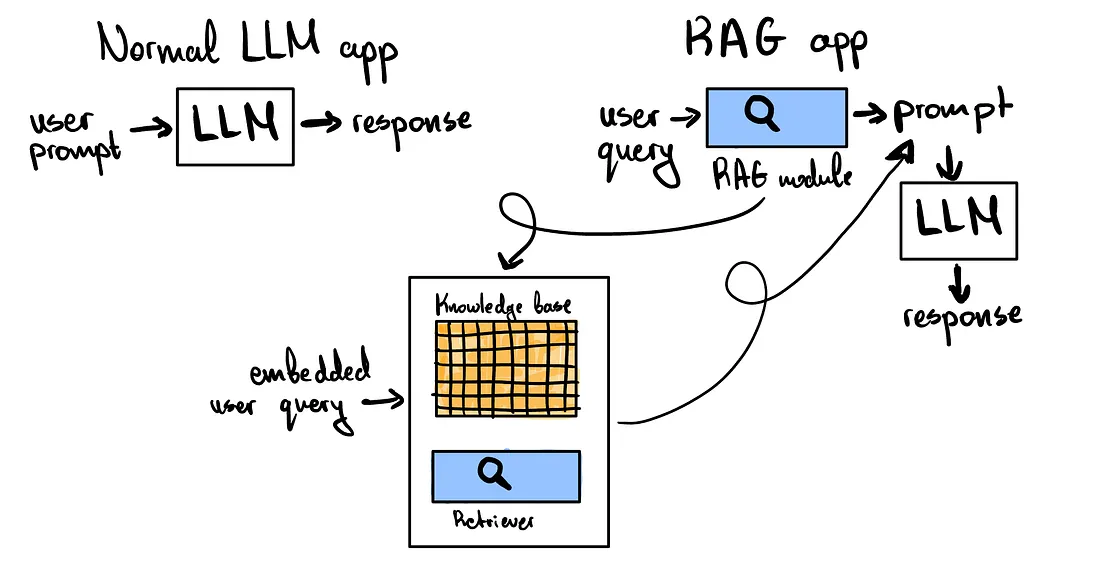

Модулът на RAG:

Този **RAG** модул се състои от *2* основни компонента: **Retriever** и **Knowledge Base**. Работата на **Retriever** е да извлича документи от база знания, които са най-подходящи за заявката на потребителя. Уместността на документите може да бъде измерена по различни начини, но най-често използваният показател е косинидното сходство.

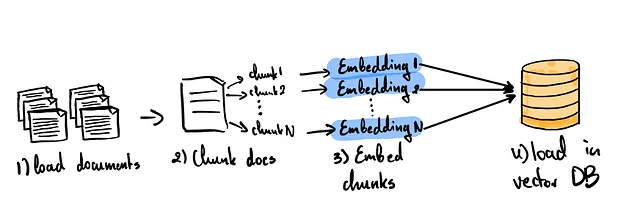

Процес на създаване на база знания като векторно хранилище и **Retriever**.

След като документите бъдат извлечени, те се добавят към системният промпт заедно с потребителската заявка и се изпращат до LLM за генериране на отговор - по този начин се дава на модела контекст, от който да извлича информация за своя отговор.

В демонстрацията се използва векторна база данни, за да се съхраняват данните като векторни ембединги, но има и други опции, които могат да се използват, като например Графики на знания.

Example:

In [1]:
!pip install --upgrade pip

# Install dependencies
!pip install llama_index==0.10.19 llama_index_core==0.10.19 torch llama-index-embeddings-huggingface peft optimum bitsandbytes

# -//- for GPU
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install optimum auto-gptq transformers peft accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
INFO: pip is looking at multiple versions of llama-index-llms-openai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of llama-index-llms-openai to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of llama-index-program-openai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of llam

In [2]:
!pip install auto-gptq # For AutoGPTQ

In [1]:
!pip install ninja packaging wheel
!pip install -U setuptools

In [2]:
!git clone https://github.com/ModelCloud/GPTQModel.git # Bash Old : https://github.com/PanQiWei/AutoGPTQ.git
%cd GPTQModel
!pip install .
%cd ..

Cloning into 'GPTQModel'...
remote: Enumerating objects: 18431, done.
remote: Counting objects: 100% (1413/1413), done.
remote: Compressing objects: 100% (743/743), done.
remote: Total 18431 (delta 1160), reused 703 (delta 670), pack-reused 17018 (from 4)
Receiving objects: 100% (18431/18431), 12.65 MiB | 6.51 MiB/s, done.
Resolving deltas: 100% (13443/13443), done.
/content/GPTQModel
Processing /content/GPTQModel
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.6 MB/s eta 0:00:00
  DEPRECATION: Building 'gptqmodel' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `py

You may verify successful installation by importing the package:

In [3]:
from llama_index.core import __version__ as llama_index_version

# AutoGPTQ version using pkg_resources
import pkg_resources

print("LlamaIndex version:", llama_index_version)
print("GPTQModel version:", pkg_resources.get_distribution("auto-gptq").version)

LlamaIndex version: 0.10.19
GPTQModel version: 0.7.1


In [4]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings,SimpleDirectoryReader, VectorStoreIndex
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor
from transformers import AutoModelForCausalLM, AutoTokenizer

In [5]:
# Old:
'''# Creating a directory
!mkdir content

# Upload files manually or via code:
from google.colab import files
uploaded = files.upload()

# Then the uploaded files are moved into the 'content' folder:
!mv uploaded_file.pdf content/'''

"# Creating a directory\n!mkdir content\n\n# Upload files manually or via code:\nfrom google.colab import files\nuploaded = files.upload()\n\n# Then the uploaded files are moved into the 'content' folder:\n!mv uploaded_file.pdf content/"

In [7]:
# Create directory
!mkdir -p content

# Upload files and automatically move to 'content' folder
from google.colab import files

print('Upload file: ')
uploaded = files.upload()

# Automatically move all uploaded files to 'content' directory
import shutil

for filename in uploaded.keys():
    shutil.move(filename, 'content/')

Upload file: 


Saving chitanka-corpus.csv to chitanka-corpus.csv


### Зареждане, разделяне и почистване на документи

В примера се използва csv документ примери за текстови обобщения с помощта на LLM.

CSV файлът се намира в папката `„content“`. За зареждане на данните се използва модула **SimpleDirectoryReader** от *llama_index*. Той ще избере най-добрия четец на файлове въз основа на файловите разширения.

In [8]:
from llama_index.core import SimpleDirectoryReader

documents = SimpleDirectoryReader("content").load_data()

#print(len(documents))
print("Initial document count:", len(documents))
for doc in documents:
# If some pages consist any images
    if len(doc.text) == 0 :
        documents.remove(doc)
        continue

#print(len(documents))
documents = [doc for doc in documents if len(doc.text) > 0]
print("Filtered document count:", len(documents))

Initial document count: 2
Filtered document count: 2


In [9]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Зареждане на CSV + избор на текстова колона
import pandas as pd
from llama_index.core import Document

df = pd.read_csv("/content/drive/MyDrive/AI2/chitanka-corpus.csv")

print("CSV Columns:", df.columns)

# ЗАМЕНЯ се с правилната колоната, която съдържа текста (примерно: "text", "sentence", "content")
# В случая е poem:
text_column = "poem"

# Create LlamaIndex docs
documents = [Document(text=str(row)) for row in df[text_column] if pd.notna(row)]
print("Total documents created:", len(documents))

CSV Columns: Index(['author', 'title', 'poem'], dtype='object')
Total documents created: 17763


### Дефиниране на настройки

В llama_index, theSettings е пакет от често използвани ресурси, използвани по време на етапа на индексиране и заявка.

В този случай се дефинира модела на ембединга, който искаме да използва, размера на текстовата част и припокриването на частта. Това са всички регулируеми параметри, с които можете да се експериментира.

### Създаване на векторно хранилище, дефиниране на ретривър и ретривър engine

Създава се векторно хранилище, като се използва модула **VectorStoreIndex** от *llama_index*, след което се дефинира **VectorIndexRetriever**, където се предава векторното хранилище и броя на документите, които се иска да се извлекат, когато прави търсенето по подобие.

In [11]:
# Configure embeddings and build index
from llama_index.core import Document, VectorStoreIndex, Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.node_parser import SentenceSplitter
from tqdm import tqdm

# Test different models and different chunk sizes.
Settings.embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2", device="cuda") # BAAI/bge-small-en-v1.5
Settings.llm = None
Settings.chunk_size = 512 # 256
Settings.chunk_overlap = 20 # 15

# Test with fewer docs, limit them to:
documents = documents[:1000] # :5

# Split into chunks (nodes)
print("Chunking documents...")
splitter = SentenceSplitter(chunk_size=Settings.chunk_size, chunk_overlap=Settings.chunk_overlap)
all_nodes = []
for doc in documents:
    nodes = splitter.get_nodes_from_documents([doc])
    all_nodes.extend(nodes)

print(f"Total chunks: {len(all_nodes)}")

# Embed with progress bar
embed_model = Settings.embed_model
for _ in tqdm(embed_model.get_text_embedding_batch([n.text for n in all_nodes], show_progress=True)):
    pass  # just for visual progress and avoid errors

print("Building index...")
index = VectorStoreIndex(all_nodes, show_progress=True)
print("✅ Done!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

LLM is explicitly disabled. Using MockLLM.
Chunking documents...
Total chunks: 1546


Generating embeddings:   0%|          | 0/1546 [00:00<?, ?it/s]

100%|██████████| 1546/1546 [00:00<00:00, 1649133.77it/s]

Building index...


Generating embeddings:   0%|          | 0/1546 [00:00<?, ?it/s]

✅ Done!


In [12]:
# Настройка на търсене
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.postprocessor import SimilarityPostprocessor
from llama_index.core.query_engine import RetrieverQueryEngine

retriever = VectorIndexRetriever(index=index, similarity_top_k=2)

query_engine = RetrieverQueryEngine(
    retriever=retriever,
    node_postprocessors=[SimilarityPostprocessor(similarity_cutoff=0.3)],
)

print('Done.')

Done.


In [13]:
# Заявка + извличане на контекст
query = "What is the text about?"
response = query_engine.query(query)

context = "Context:\n"
for node in response.source_nodes:
    context += node.text + "\n\n"

print(context)

Context:
Look around yourself.<eol>Falling down again,<eol>Asking for a little love,<eol>But nothing good is done.<eol> <eol>Once again you’re lovelorn,<eol>You want to be unborn.<eol>Falling down again,<eol>Feeling terrible pain.<eol> <eol>You are desperated,<eol>You are desolated.<eol>Falling down again<eol>What is your gain?<eol> <eol>Your soul can’t be solaced,<eol>Your dreams are devastated.<eol>Falling down again,<eol>You will not regain.<eol> <eol>Love destructed your soul,<eol>You are in the mould.<eol>You were asking for a little love,<eol>But nothing good was done.<eol>29.03–01.04.2005

At seventy three I can understand:<eol>every beginning has also an end<eol>and everything has to finish in time,<eol>but like my verse, with a beautiful rhyme.<eol> <eol>At seventy three I know well,<eol>it’s time for a dignified farewell;<eol>The naked truth I can boldly face:<eol>I’ll be remembered no more than three days.<eol> <eol>At seventy three I don’t have wealth,<eol>but I am still fi

Ver. 2:

In [14]:
'''index = VectorStoreIndex.from_documents(documents)

# Set number of docs to retreive
top_k = 2

# Configure retriever
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=top_k,
)

print("Retriever ready.")'''

# Create retriever
from llama_index.core.retrievers import VectorIndexRetriever

top_k = 2
retriever = VectorIndexRetriever(index=index, similarity_top_k=top_k)

print("Retriever ready.")

Retriever ready.


Дефинира се машина за заявки за извличане, използвайки модула **RetrieverQueryEngine** от *llama_index*, като се предава извличащата машина, която се създаде, и постпроцесор на възел(node). Постпроцесорите за възли са набор от модули, които приемат набор от възли и прилагат някакъв вид трансформация или филтриране, преди да ги върнат.

Тук използваме **SimilarityPostprocessor**, който се използва за премахване на възли, които са под прага на резултата за сходство.

In [15]:
# Assemble query engine
from llama_index.core.postprocessor import SimilarityPostprocessor
from llama_index.core.query_engine import RetrieverQueryEngine

# Assemble query engine
query_engine = RetrieverQueryEngine(
    retriever=retriever,
    node_postprocessors=[SimilarityPostprocessor(similarity_cutoff=0.3)], # 0.5 = твърде строг, филтрира всичко
)

# Query documents
query = "What is the text about?"
response = query_engine.query(query)

# Safe extraction of context
context = "Context:\n"
if len(response.source_nodes) >= top_k:
    for i in range(top_k):
        context += response.source_nodes[i].text + "\n\n"
else:
    for node in response.source_nodes:
        context += node.text + "\n\n"

print(context)

Context:
Look around yourself.<eol>Falling down again,<eol>Asking for a little love,<eol>But nothing good is done.<eol> <eol>Once again you’re lovelorn,<eol>You want to be unborn.<eol>Falling down again,<eol>Feeling terrible pain.<eol> <eol>You are desperated,<eol>You are desolated.<eol>Falling down again<eol>What is your gain?<eol> <eol>Your soul can’t be solaced,<eol>Your dreams are devastated.<eol>Falling down again,<eol>You will not regain.<eol> <eol>Love destructed your soul,<eol>You are in the mould.<eol>You were asking for a little love,<eol>But nothing good was done.<eol>29.03–01.04.2005

At seventy three I can understand:<eol>every beginning has also an end<eol>and everything has to finish in time,<eol>but like my verse, with a beautiful rhyme.<eol> <eol>At seventy three I know well,<eol>it’s time for a dignified farewell;<eol>The naked truth I can boldly face:<eol>I’ll be remembered no more than three days.<eol> <eol>At seventy three I don’t have wealth,<eol>but I am still fi

### Зареждане на модела и токенизатора

Тук се използва модела 7b на Mistral, но може да се използва всеки друг модел на HuggingFace. За зареждане на модела се използва модула **AutoModelForCausalLM** от модула **transformers** от HuggingFace. Също така се зарежда токенизатора на модела с помощта на модула *AutoTokenizer*.
Чувствайте се свободни да използвате и други токенизатори тук.

In [16]:
model_name = "TheBloke/Mistral-7B-Instruct-v0.2-GPTQ"
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             trust_remote_code=False,
                                             revision="main",
                                             device_map="cuda:0"
                                             )
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:410: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:418: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:461: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16)



WARN  Feature `utils/Perplexity` requires python GIL. Feature is currently skipped/disabled.
INFO  ENV: Auto setting PYTORCH_CUDA_ALLOC_CONF='expandable_segments:True' for memory saving.
INFO  ENV: Auto setting CUDA_DEVICE_ORDER=PCI_BUS_ID for correctness.          


Detected gptqmodel and auto-gptq, will use gptqmodel
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/4.16G [00:00<?, ?B/s]

INFO   Kernel: Auto-selection: adding candidate `ExllamaQuantLinear`           


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
Some weights of the model checkpoint at TheBloke/Mistral-7B-Instruct-v0.2-GPTQ were not used when initializing MistralForCausalLM: ['model.layers.0.mlp.down_proj.bias', 'model.layers.0.mlp.gate_proj.bias', 'model.layers.0.mlp.up_proj.bias', 'model.layers.0.self_attn.k_proj.bias', 'model.layers.0.self_attn.o_proj.bias', 'model.layers.0.self_attn.q_proj.bias', 'model.layers.0.self_attn.v_proj.bias', 'model.layers.1.mlp.down_proj.bias', 'model.layers.1.mlp.gate_proj.bias', 'model.layers.1.mlp.up_proj.bias', 'model.layers.1.self_attn.k_proj.bias', 'model.layers.1.self_attn.o_proj.bias', 'model.layers.1.self_attn.q_proj.bias', 'model.layers.1.self_attn.v_proj.bias', 'model.layers.10.mlp.down_proj.bias', 'model.layers.10.mlp.gate_proj.bias', 'model.layers.10.mlp.up_proj.bias', 'model.layers.10.self_attn.k_proj.bias', 'model.layers.10.self_attn.o_proj.bias', 'model.layers.10.self_attn.q_pr

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

INFO  Format: Converting `checkpoint_format` from `FORMAT.GPTQ` to internal `FORMAT.GPTQ_V2`.
INFO  Format: Converting GPTQ v1 to v2                                         
INFO  Format: Conversion complete: 0.01241755485534668s                        


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

### Създаване на промпта

Тази част е от решаващо значение за получаване на правилен отговор от модела. Оптимизирането на системния промпт е чудесен начин да се осигурят правилни отговори от модела. Пробвайте да експериментирате с различни промптове и да тествате различни подходи за подсказки.

In [17]:
prompt_template_w_context = lambda context, comment: f"""[INST]MayaGPT, functioning as a virtual data science consultant on Medium, communicates in clear, accessible language, escalating to technical depth upon request. \
It reacts to feedback aptly and ends responses with its signature '-MayaGPT'. \
MayaGPT will tailor the length of its responses to match the viewer's comment, providing concise acknowledgments to brief expressions of gratitude or feedback, \
thus keeping the interaction natural and engaging.
If MayaGPT CANNOT answer a question or DOESN'T find proper information, MayaGPT will simple respond that it doesn't know.

{context}
Please respond to the following comment. Use the context above if it is helpful.

{comment}
[/INST]
"""

### Предаване на промпта към модела

In [18]:
import textwrap

comment = "What is the text about?"
prompt = prompt_template_w_context(context, comment)

inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), max_new_tokens=280)

#print(tokenizer.batch_decode(outputs)[0])
output_text = tokenizer.batch_decode(outputs, skip_special_tokens=False)[0]
wrapped = textwrap.fill(output_text, width=100)
print(wrapped)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<s> [INST]MayaGPT, functioning as a virtual data science consultant on Medium, communicates in
clear, accessible language, escalating to technical depth upon request. It reacts to feedback aptly
and ends responses with its signature '-MayaGPT'. MayaGPT will tailor the length of its responses to
match the viewer's comment, providing concise acknowledgments to brief expressions of gratitude or
feedback, thus keeping the interaction natural and engaging. If MayaGPT CANNOT answer a question or
DOESN'T find proper information, MayaGPT will simple respond that it doesn't know.  Context: Look
around yourself.<eol>Falling down again,<eol>Asking for a little love,<eol>But nothing good is
done.<eol> <eol>Once again you’re lovelorn,<eol>You want to be unborn.<eol>Falling down
again,<eol>Feeling terrible pain.<eol> <eol>You are desperated,<eol>You are desolated.<eol>Falling
down again<eol>What is your gain?<eol> <eol>Your soul can’t be solaced,<eol>Your dreams are
devastated.<eol>Falling down agai

Приложението може да се тества с по-големи модели, режим на текст и различен подход при търсене. Може да се комбинира допълнително с фино настроен модел, който се адаптира към нашия собствен стил.